### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score

import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy.stats import pearsonr

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

pd.set_option('display.float_format',lambda x: '%.5f' %x)

import warnings
warnings.filterwarnings("ignore")

### Load the dataset

In [2]:
# # Load the datasets for 2019 data
# data2019 = pd.read_csv(r'C:\Users\abandyopadhyay\ALOKPARNA\RCV_SLOTTING\Dataset\Slotting_2019.csv', header=0, encoding = 'unicode_escape')
# print("----- Feature Set ----- \n", list(data2019.columns))

# data2019 = data2019.fillna(0)

# Load the datasets for 2018 data
data2019 = pd.read_csv(r'C:\Users\abandyopadhyay\ALOKPARNA\RCV_SLOTTING\Dataset\Slotting_2018.csv', header=0, encoding = 'unicode_escape')
print("----- Feature Set ----- \n", list(data2019.columns))

this_year = 2018

data2019 = data2019.fillna(0)

----- Feature Set ----- 
 ['UniqueId', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'Season_SKU_Introduced', 'Year_SKU_Introduced', 'History_Size_Pct', 'Month', 'Season', 'Year', 'Quarter', 'PlannedUnits', 'PDXPlannedUnits', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Experiment_Id']


### Function Definitions

In [3]:
# Function to identify whether a product is new or not and add that as a feature in the dataset
def add_new_product(data):
    data.loc[(data.Year_SKU_Introduced < this_year) | ((data['Year_SKU_Introduced']).isnull()), 'NewProduct'] = '0' # Existing product
    data.loc[data.Year_SKU_Introduced >= this_year, 'NewProduct'] = '1' # New product
    return (data)

In [4]:
# Function to add 'Demand' as a feature in the dataset
def add_demand(data):
    data.loc[data.PlannedUnits != 0, 'Demand'] = data['PlannedUnits']
    data.loc[data.PlannedUnits == 0, 'Demand'] = data['PDXPlannedUnits']

    return (data)

In [5]:
# Function to Group products by Experiment Id
def group_by_expId(data):
    groupedData = data.groupby(['Experiment_Id']).agg({'Demand': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove the index and flatten the 2019 dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (by Experiment Id) shape: ", groupedData.shape)
    return (groupedData)

In [6]:
# Function to Group products by Experiment Id and Seasons
def group_by_Seasons(data):
    groupedData = data.groupby(['Experiment_Id', 'Season']).agg({'Demand': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove the index and flatten the 2019 dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (by Experiment Id and Seasons) shape: ", groupedData.shape)
    return (groupedData)

In [7]:
# Function to Group products by Experiment Id and Categorical Descriptions
def group_by_Categoricals(data):
    groupedData = data.groupby(['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Demand': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove index and flatten the dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (Experiment Id and Categoricals) shape: ", groupedData.shape)
    return (groupedData)

In [8]:
# Function to Group products by Experiment Id, Seasons and Categorical Descriptions
def group_by_SeasonsAndCategoricals(data):
    groupedData = data.groupby(['Experiment_Id', 'Season', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Demand': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove index and flatten the dataset
    groupedData.reset_index(inplace=True)
    print("\nGrouped dataset (Experiment Id, Seasons and Categoricals) shape: ", groupedData.shape)
    return (groupedData)

In [9]:
# Function to select the Top80 selling products
def get_Top80(data):
    # Calculate % Ordered_Units 
    totalOrdUnits = data['Ordered_Units'].sum()
    data['Pct_OrdUnits'] = (data['Ordered_Units']/totalOrdUnits)*100

    # Sort the dataset based on % Ordered_Units 
    data = data.sort_values('Pct_OrdUnits',ascending=False)
    data['Cumsum_Pct_OrdUnits'] = data['Pct_OrdUnits'].cumsum()

    # Find the orders with Top 80 sales (ordered units)
    dataTop80 = data[data.Cumsum_Pct_OrdUnits <= 80]

    # Drop the Pct_OrdUnits and Cumsum_Pct_OrdUnits columns
    dataTop80 = dataTop80.drop(['Pct_OrdUnits', 'Cumsum_Pct_OrdUnits'], axis=1)

    print("Dataset shape after retaining the Top80 selling products: ", dataTop80.shape)
    return (dataTop80)

In [10]:
# Function for K-Means clustering
def KMeans_clusterLabels(data, n):# Cluster data using k-means and get the cluster labels
    model = KMeans(n_clusters=n, random_state=1)
    model.fit(data)
    model2019 = model.predict(data)
    # Get cluster labels
    cluster_label = model.labels_
    #Plot the clusters
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=model2019, s=50, cmap='viridis')
    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    
    # Recoding the Cluster '0' as Cluster 'n'
    for i in range(len(cluster_label)): 
        if cluster_label[i] == 0:
            cluster_label[i] = n
    
    return (cluster_label)

In [11]:
# Function for adding binary values for ClusterLabels
def add_binary_response_clusterLabels(data):
    data.loc[data.Cluster3_Label == 1, 'Cluster_1'] = '1'
    data.loc[data.Cluster3_Label != 1, 'Cluster_1'] = '0'
    
    data.loc[data.Cluster3_Label == 2, 'Cluster_2'] = '1'
    data.loc[data.Cluster3_Label != 2, 'Cluster_2'] = '0'
    
    data.loc[data.Cluster3_Label == 3, 'Cluster_3'] = '1'
    data.loc[data.Cluster3_Label != 3, 'Cluster_3'] = '0'
    
    return (data)

In [12]:
# Function for creating Classification Dataset
def create_Classification_Dataset(data):
    # Add the new feature 'Suggested_Storage_Type' and the target 'Class' based on the 'Avg_Daily_Volume'
    data.loc[data.Avg_Daily_Volume <= 4216.22, 'Suggested_Storage_Type'] = 'Flat Rack'
    data.loc[data.Avg_Daily_Volume <= 4216.22, 'Class'] = '1'
    data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Suggested_Storage_Type'] = 'Flow Rack' 
    data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Class'] = '2' 
    data.loc[data.Avg_Daily_Volume > 21081.6, 'Suggested_Storage_Type'] = 'Big Pack'
    data.loc[data.Avg_Daily_Volume > 21081.6, 'Class'] = '3'

    return (data)

In [13]:
# Function to calculate Pearson Co-edfficient and p-values of a matrix
def corrcoef_loop(matrix):
    rows, cols = matrix.shape[0], matrix.shape[1]
    r = np.ones(shape=(rows, rows))
    p = np.ones(shape=(rows, rows))
    for i in range(rows):
        for j in range(i+1, rows):
            r_, p_ = pearsonr(matrix[i], matrix[j])
            r[i, j] = r[j, i] = r_
            p[i, j] = p[j, i] = p_
    return r, p

### Dataset ETL and Selection of Top80 Sales

In [14]:
# Remove those Data for which there are no Orders
dfOrders2019 = data2019[data2019.Orders != 0]

# Add a new feature to identify whether a product is New or Existing
dfOrders2019 = add_new_product(dfOrders2019)
print("0: Existing Product; 1: New Product")
print(dfOrders2019['NewProduct'].value_counts())

# Add a new feature 'Demand'
dfOrders2019 = add_demand(dfOrders2019)

# # Group 2019 dataset by Experiment_Id
# grouped2019 = group_by_expId(dfOrders2019)

# # Group 2019 dataset by Experiment_Id and Seasons
# groupedSeasons2019 = group_by_Seasons(dfOrders2019)
# groupedSpring2019 = groupedSeasons2019.loc[groupedSeasons2019['Season'] == 0].drop(['Season'], axis=1)
# groupedFall2019 = groupedSeasons2019.loc[groupedSeasons2019['Season'] == 1].drop(['Season'], axis=1)
# print("Spring2019 dataset shape: ", groupedSpring2019.shape)
# print("Fall2019 dataset shape: ", groupedFall2019.shape)

# # Group 2019 dataset by Experiment_Id and Categorical Descriptions
# groupedCat2019 = group_by_Categoricals(dfOrders2019)

# Group 2019 dataset by Experiment_Id, Seasons and Categoricals
groupedCatSeasons2019 = group_by_SeasonsAndCategoricals(dfOrders2019)

groupedCatSpring2019 = groupedCatSeasons2019.loc[groupedCatSeasons2019['Season'] == 0].drop(['Season'], axis=1)
groupedCatFall2019 = groupedCatSeasons2019.loc[groupedCatSeasons2019['Season'] == 1].drop(['Season'], axis=1)
print("Spring2019 with categorical dataset shape: ", groupedCatSpring2019.shape)
print("Fall2019 with categorical dataset shape: ", groupedCatFall2019.shape)

# Get Top80 most sold products
# df2019_Top80 = get_Top80(grouped2019)
# dfSpring2019_Top80 = get_Top80(groupedSpring2019)
# dfFall2019_Top80 = get_Top80(groupedFall2019)

# dfCat2019_Top80 = get_Top80(groupedCat2019)
dfCatSpring2019_Top80 = get_Top80(groupedCatSpring2019)
dfCatFall2019_Top80 = get_Top80(groupedCatFall2019)

print("\n----- Feature Set : dfCatSpring2019_Top80 ----- \n", list(dfCatSpring2019_Top80.columns))
print("\n----- Feature Set : dfCatFall2019_Top80 ----- \n", list(dfCatFall2019_Top80.columns))

0: Existing Product; 1: New Product
0    131966
1     25081
Name: NewProduct, dtype: int64

Grouped dataset (Experiment Id, Seasons and Categoricals) shape:  (33005, 21)
Spring2019 with categorical dataset shape:  (15050, 20)
Fall2019 with categorical dataset shape:  (17955, 20)
Dataset shape after retaining the Top80 selling products:  (2280, 20)
Dataset shape after retaining the Top80 selling products:  (2548, 20)

----- Feature Set : dfCatSpring2019_Top80 ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']

----- Feature Set : dfCatFall2019_Top80 ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered

In [15]:
# # Cluster 2019 dataset (without categorical descriptions) by K-Means Clustering
# df2019_Top80_kmeans = df2019_Top80.copy()

# # Add the cluster labels to the dataset
# # Number of clusters : 3
# cluster3_label = KMeans_clusterLabels(df2019_Top80, 3)
# df2019_Top80_kmeans['Cluster3_Label'] = cluster3_label

# print("\n----- 2019 Cluster_Label counts -----")
# print(df2019_Top80_kmeans['Cluster3_Label'].value_counts())

In [16]:
# # Number of clusters : 4
# cluster4_label = KMeans_clusterLabels(df2019_Top80, 4)
# df2019_Top80_kmeans['Cluster4_Label'] = cluster4_label

# print("\n----- 2019 Cluster_Label counts -----")
# print(df2019_Top80_kmeans['Cluster4_Label'].value_counts())

In [17]:
# # Remove the order details and retain only the cluster labels along with the Experiment_Id
# df2019_Top80_kmeans_labels = df2019_Top80_kmeans.drop(['Demand', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume'], axis=1)
# print("Dataset shape: ", df2019_Top80_kmeans_labels.shape)

# # Clustering Accuracy : Calculate Silhouette Coefficient
# # Evaluate the 3-cluster model
# accuracyCluster3 = silhouette_score(df2019_Top80, cluster3_label)
# print("Accuracy of kmeans with n=3: ", accuracyCluster3)
# # Evaluate the 4-cluster model
# accuracyCluster4 = silhouette_score(df2019_Top80, cluster4_label)
# print("Accuracy of kmeans with n=4: ", accuracyCluster4)

### Feature Selection for Clustering

In [77]:
CLUSTERING_FEATURE_SET_1 = ['Volume', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume']
CLUSTERING_FEATURE_SET_2 = ['Volume', 'Orders', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume']
CLUSTERING_FEATURE_SET_3 = ['Volume', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Avg_Daily_Volume']
CLUSTERING_FEATURE_SET_4 = ['Volume', 'Orders', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Avg_Daily_Volume']

CLUSTERING_FEATURE_SET = CLUSTERING_FEATURE_SET_4

dfSpring2019_Top80_kmeans = dfCatSpring2019_Top80[CLUSTERING_FEATURE_SET]
dfFall2019_Top80_kmeans = dfCatFall2019_Top80[CLUSTERING_FEATURE_SET]

### Calculate Corelation of Selected Features

In [78]:
corr_Spring = dfSpring2019_Top80_kmeans.corr()
corr_Spring.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Orders,Avg_Daily_Ordered_Units,Days_Ordered,Avg_Daily_Volume
Volume,1,-0.17904,-0.170369,-0.162131,0.140378
Orders,-0.17904,1,0.739503,0.261513,0.108798
Avg_Daily_Ordered_Units,-0.170369,0.739503,1,-0.0215096,0.417626
Days_Ordered,-0.162131,0.261513,-0.0215096,1,-0.268774
Avg_Daily_Volume,0.140378,0.108798,0.417626,-0.268774,1


In [79]:
corr_Fall = dfFall2019_Top80_kmeans.corr()
corr_Fall.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Orders,Avg_Daily_Ordered_Units,Days_Ordered,Avg_Daily_Volume
Volume,1,-0.052581,-0.0693867,-0.258583,0.410069
Orders,-0.052581,1,0.627742,0.210558,0.137326
Avg_Daily_Ordered_Units,-0.0693867,0.627742,1,-0.070216,0.267411
Days_Ordered,-0.258583,0.210558,-0.070216,1,-0.445695
Avg_Daily_Volume,0.410069,0.137326,0.267411,-0.445695,1


### Calculate 'p-value' of Corelation matrix

In [80]:
# Find p-values (p) of Spring Corelation Matrix
r, p = corrcoef_loop(corr_Spring.values)

# Convert the p-value matrix into a dataframe for plotting
p_df = pd.DataFrame(p)
p_df.columns = CLUSTERING_FEATURE_SET
p_df.index = CLUSTERING_FEATURE_SET

p_df.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Orders,Avg_Daily_Ordered_Units,Days_Ordered,Avg_Daily_Volume
Volume,1,0.121236,0.228979,0.400857,0.92289
Orders,0.121236,1,0.0776738,0.747247,0.846451
Avg_Daily_Ordered_Units,0.228979,0.0776738,1,0.68439,0.535632
Days_Ordered,0.400857,0.747247,0.68439,1,0.10418
Avg_Daily_Volume,0.92289,0.846451,0.535632,0.10418,1


In [81]:
# Find p-values (p) of Fall Corelation Matrix
r, p = corrcoef_loop(corr_Fall.values)

# Convert the p-value matrix into a dataframe for plotting
p_df = pd.DataFrame(p)
p_df.columns = CLUSTERING_FEATURE_SET
p_df.index = CLUSTERING_FEATURE_SET

p_df.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Orders,Avg_Daily_Ordered_Units,Days_Ordered,Avg_Daily_Volume
Volume,1,0.254676,0.468817,0.193734,0.290533
Orders,0.254676,1,0.127564,0.786327,0.714848
Avg_Daily_Ordered_Units,0.468817,0.127564,1,0.684091,0.811642
Days_Ordered,0.193734,0.786327,0.684091,1,0.0168484
Avg_Daily_Volume,0.290533,0.714848,0.811642,0.0168484,1


### Calculate 'Confidence Interval' of clustering dataset

In [82]:
# Calculate confidence interval of Spring2019 dataset
confInt_Spring =  pd.DataFrame(sms.DescrStatsW(dfSpring2019_Top80_kmeans).tconfint_mean(),
                               columns=CLUSTERING_FEATURE_SET)
print('\n----- Confidence interval of Spring2019 dataset -----\n\n', confInt_Spring)

# Calculate confidence interval of Fall2019 dataset
confInt_Fall = pd.DataFrame(sms.DescrStatsW(dfFall2019_Top80_kmeans).tconfint_mean(),
                            columns=CLUSTERING_FEATURE_SET)
print('\n----- Confidence interval of Fall2019 dataset -----\n\n', confInt_Fall)


----- Confidence interval of Spring2019 dataset -----

      Volume     Orders  Avg_Daily_Ordered_Units  Days_Ordered  \
0 223.86573 1622.20359                149.45029     143.12856   
1 241.75430 1809.80606                169.12603     145.95916   

   Avg_Daily_Volume  
0        4939.92146  
1        6389.96251  

----- Confidence interval of Fall2019 dataset -----

      Volume     Orders  Avg_Daily_Ordered_Units  Days_Ordered  \
0 380.62211 1994.16167                207.58686     159.07058   
1 411.25511 2180.49767                263.45867     161.96003   

   Avg_Daily_Volume  
0       13717.61586  
1       17234.94586  


### K-Means Clustering


----- Spring 2019 Cluster_Label counts with n=3 -----
3    2193
2      80
1       7
Name: Cluster3_Label, dtype: int64
Accuracy of kmeans with n=3 on Spring2019:  0.83418725863884


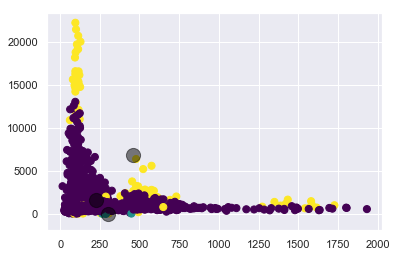

In [83]:
# Cluster Spring 2019 by K-Means Clustering
# Kmeans with n=3 on Spring2019 Data
spring_cluster3_label = KMeans_clusterLabels(dfSpring2019_Top80_kmeans, 3)
dfCatSpring2019_Top80['Cluster3_Label'] = spring_cluster3_label

print("\n----- Spring 2019 Cluster_Label counts with n=3 -----")
print(dfCatSpring2019_Top80['Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Spring2019
accuracySpring = silhouette_score(dfSpring2019_Top80_kmeans, spring_cluster3_label)
print("Accuracy of kmeans with n=3 on Spring2019: ", accuracySpring)

# Add binary response values for each Cluster Labels
dfCatSpring2019_Top80 = add_binary_response_clusterLabels(dfCatSpring2019_Top80)


----- Spring 2019 Cluster_Label counts with n=4 -----
4    1978
2     275
3      20
1       7
Name: Cluster4_Label, dtype: int64
Accuracy of kmeans with n=4 on Spring2019:  0.7058245181905407


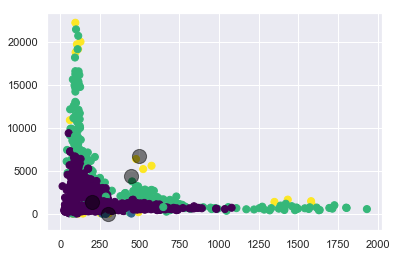

In [84]:
# Cluster Spring 2019 by K-Means Clustering
# Kmeans with n=4 on Spring2019 Data
spring_cluster4_label = KMeans_clusterLabels(dfSpring2019_Top80_kmeans, 4)
dfCatSpring2019_Top80['Cluster4_Label'] = spring_cluster4_label

print("\n----- Spring 2019 Cluster_Label counts with n=4 -----")
print(dfCatSpring2019_Top80['Cluster4_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 4-cluster model for Spring2019
accuracySpring = silhouette_score(dfSpring2019_Top80_kmeans, spring_cluster4_label)
print("Accuracy of kmeans with n=4 on Spring2019: ", accuracySpring)


----- Fall 2019 Cluster_Label counts with n=3 -----
3    2483
2      51
1      14
Name: Cluster3_Label, dtype: int64
Accuracy of kmeans with n=3 on Fall2019:  0.9079624981982863


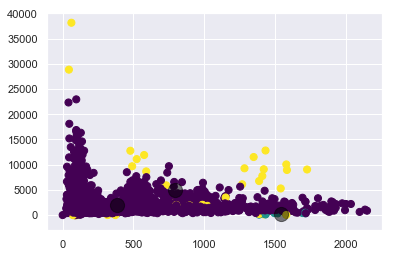

In [85]:
# Cluster Fall 2019 by K-Means Clustering
# Kmeans with n=3 on Fall2019 Data
fall_cluster3_label = KMeans_clusterLabels(dfFall2019_Top80_kmeans, 3)
dfCatFall2019_Top80['Cluster3_Label'] = fall_cluster3_label

print("\n----- Fall 2019 Cluster_Label counts with n=3 -----")
print(dfCatFall2019_Top80['Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Fall2019
accuracyFall = silhouette_score(dfFall2019_Top80_kmeans, fall_cluster3_label)
print("Accuracy of kmeans with n=3 on Fall2019: ", accuracyFall)

# Add binary response values for each Cluster Labels
dfCatFall2019_Top80 = add_binary_response_clusterLabels(dfCatFall2019_Top80)


----- Fall 2019 Cluster_Label counts with n=4 -----
4    2346
3     170
2      22
1      10
Name: Cluster4_Label, dtype: int64
Accuracy of kmeans with n=4 on Fall2019:  0.8068154971965216


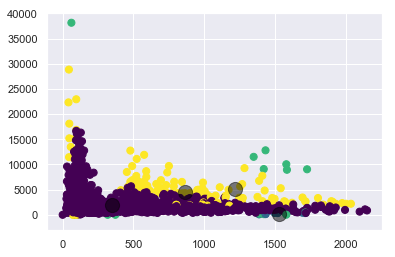

In [86]:
# Cluster Fall 2019 by K-Means Clustering
# Kmeans with n=4 on Fall2019 Data
fall_cluster4_label = KMeans_clusterLabels(dfFall2019_Top80_kmeans, 4)
dfCatFall2019_Top80['Cluster4_Label'] = fall_cluster4_label

print("\n----- Fall 2019 Cluster_Label counts with n=4 -----")
print(dfCatFall2019_Top80['Cluster4_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 4-cluster model for Fall2019
accuracyFall = silhouette_score(dfFall2019_Top80_kmeans, fall_cluster4_label)
print("Accuracy of kmeans with n=4 on Fall2019: ", accuracyFall)

In [28]:
# Create datasets for Classification (2019, Spring2019 and Fall2019)
# df2019 = create_Classification_Dataset(dfCat2019_Top80, df2019_Top80_kmeans_labels)
# print("2019 dataset shape: ", df2019.shape)
# print("----- Feature Set ----- \n", list(df2019.columns))

dfSpring2019 = create_Classification_Dataset(dfCatSpring2019_Top80)
print("Spring 2019 dataset shape: ", dfSpring2019.shape)
print("----- Feature Set ----- \n", list(dfSpring2019.columns))
print("\n")
dfFall2019 = create_Classification_Dataset(dfCatFall2019_Top80)
print("Fall 2019 dataset shape: ", dfFall2019.shape)
print("----- Feature Set ----- \n", list(dfFall2019.columns))

Spring 2019 dataset shape:  (2280, 26)
----- Feature Set ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Cluster3_Label', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Suggested_Storage_Type', 'Class']


Fall 2019 dataset shape:  (2548, 26)
----- Feature Set ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Cluster3_Label', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Suggested_Storage_Type', 'Class']


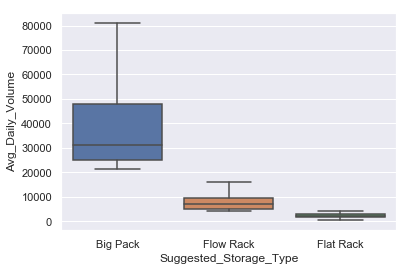

In [29]:
sns.boxplot(x='Suggested_Storage_Type', y='Avg_Daily_Volume', data=dfSpring2019, showfliers=False)

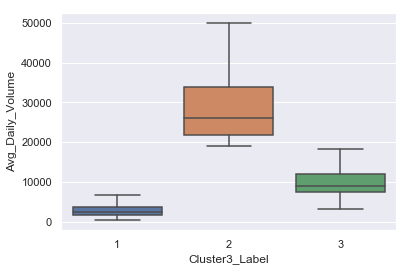

In [30]:
sns.boxplot(x='Cluster3_Label', y='Avg_Daily_Volume', data=dfSpring2019, showfliers=False)

In [31]:
# sns.boxplot(x='Cluster4_Label', y='Avg_Daily_Volume', data=dfSpring2019, showfliers=False)

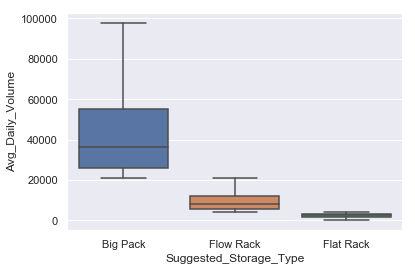

In [32]:
sns.boxplot(x='Suggested_Storage_Type', y='Avg_Daily_Volume', data=dfFall2019, showfliers=False)

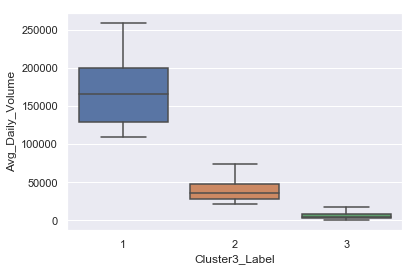

In [33]:
sns.boxplot(x='Cluster3_Label', y='Avg_Daily_Volume', data=dfFall2019, showfliers=False)

In [34]:
# sns.boxplot(x='Cluster4_Label', y='Avg_Daily_Volume', data=dfFall2019, showfliers=False)

### Classification - Multinomial Logistic Regression

In [35]:
# Create one-vs-rest multinomial logistic regression object
clf = LogisticRegression(random_state=0, multi_class='ovr', solver='newton-cg')

# FEATURE_SET = ['NewProduct', 'Demand', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']
FEATURE_SET = ['NewProduct', 'Demand', 'Ordered_Units','Order_Volume']

TARGET_CLUSTER = ['Cluster3_Label']
TARGET_CLASS = ['Class']

# SPRING DATA
spring_X = dfSpring2019[FEATURE_SET] # Spring Training Set
# spring_y1 = dfSpring2019[TARGET_CLUSTER] # Target: 3-cluster labels
spring_y2 = dfSpring2019[TARGET_CLASS]    # Target: Class (Dale's classification)
spring_cluster_y1 = dfSpring2019['Cluster_1'] # Target: Spring Cluster_1 binary response
spring_cluster_y2 = dfSpring2019['Cluster_2'] # Target: Spring Cluster_2 binary response
spring_cluster_y3 = dfSpring2019['Cluster_3'] # Target: Spring Cluster_3 binary response

# FALL DATA
fall_X = dfFall2019[FEATURE_SET] # Fall Training Set
# fall_y1 = dfFall2019[TARGET_CLUSTER] # Target: 3-cluster labels
fall_y2 = dfFall2019[TARGET_CLASS]    # Target: Class (Dale's classification)
fall_cluster_y1 = dfFall2019['Cluster_1'] # Target: Fall Cluster_1 binary response
fall_cluster_y2 = dfFall2019['Cluster_2'] # Target: Fall Cluster_2 binary response
fall_cluster_y3 = dfFall2019['Cluster_3'] # Target: Fall Cluster_3 binary response

In [36]:
#Corelation matrix of Features: Spring Data
corr_Spring = spring_X.corr()
corr_Spring.style.background_gradient(cmap='coolwarm', axis=None)

,Demand,Ordered_Units,Order_Volume
Demand,1,0.987248,0.650036
Ordered_Units,0.987248,1,0.666191
Order_Volume,0.650036,0.666191,1


In [37]:
# Find p-values (p) of Spring Corelation Matrix
r, p = corrcoef_loop(corr_Spring.values)

# Convert the p-value matrix into a dataframe for plotting
p_df = pd.DataFrame(p)
# p_df.columns = FEATURE_SET
# p_df.index = FEATURE_SET

p_df.style.background_gradient(cmap='coolwarm', axis=None)

,0,1,2
0,1,0.0419175,0.0055824
1,0.0419175,1,0.0474999
2,0.0055824,0.0474999,1


In [38]:
#Corelation matrix of Features: Fall Data
corr_Fall = fall_X.corr()
corr_Fall.style.background_gradient(cmap='coolwarm', axis=None)

,Demand,Ordered_Units,Order_Volume
Demand,1,0.978535,0.437726
Ordered_Units,0.978535,1,0.444565
Order_Volume,0.437726,0.444565,1


In [39]:
# Find p-values (p) of Fall Corelation Matrix
r, p = corrcoef_loop(corr_Fall.values)

# Convert the p-value matrix into a dataframe for plotting
p_df = pd.DataFrame(p)
# p_df.columns = FEATURE_SET
# p_df.index = FEATURE_SET

p_df.style.background_gradient(cmap='coolwarm', axis=None)

,0,1,2
0,1,0.0431671,0.0147018
1,0.0431671,1,0.0284653
2,0.0147018,0.0284653,1


#### Multinomial Logit - Fit Statistics

In [40]:
# Train Model and get the Fit Statistics
# Target: Spring Cluster_1 binary response
logit_model=sm.Logit(spring_cluster_y1.astype(float),spring_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.676859
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Cluster_1   No. Observations:                 2280
Model:                          Logit   Df Residuals:                     2276
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Sep 2019   Pseudo R-squ.:                 -0.4188
Time:                        09:49:34   Log-Likelihood:                -1543.2
converged:                       True   LL-Null:                       -1087.7
                                        LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct        1.6567      0.235      7.053      0.000       1.196       2.117
Demand        -4.537

In [41]:
# Train Model and get the Fit Statistics
# Target: Spring Cluster_2 binary response
logit_model=sm.Logit(spring_cluster_y2.astype(float),spring_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.480261
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Cluster_2   No. Observations:                 2280
Model:                          Logit   Df Residuals:                     2276
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Sep 2019   Pseudo R-squ.:                  -4.040
Time:                        09:49:34   Log-Likelihood:                -1095.0
converged:                       True   LL-Null:                       -217.27
                                        LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct       -2.9918      0.591     -5.062      0.000      -4.150      -1.833
Demand           -0.

In [42]:
# Train Model and get the Fit Statistics
# Target: Spring Cluster_3 binary response
logit_model=sm.Logit(spring_cluster_y3.astype(float),spring_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.659912
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Cluster_3   No. Observations:                 2280
Model:                          Logit   Df Residuals:                     2276
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Sep 2019   Pseudo R-squ.:                 -0.4763
Time:                        09:49:34   Log-Likelihood:                -1504.6
converged:                       True   LL-Null:                       -1019.2
                                        LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct       -1.5647      0.250     -6.252      0.000      -2.055      -1.074
Demand            0.

In [43]:
# Train Model and get the Fit Statistics
# Target: Fall Cluster_1 binary response
logit_model=sm.Logit(fall_cluster_y1.astype(float),fall_X.astype(float))
result=logit_model.fit()
print(result.summary())

         Current function value: 0.243777
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              Cluster_1   No. Observations:                 2548
Model:                          Logit   Df Residuals:                     2544
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Sep 2019   Pseudo R-squ.:                  -6.614
Time:                        09:49:34   Log-Likelihood:                -621.14
converged:                      False   LL-Null:                       -81.582
                                        LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct      -34.0347   8.99e+05  -3.79e-05      1.000   -1.76e+06    1.76e+06
Demand           -0.0020      0.000    -18.770      0.00

In [44]:
# Train Model and get the Fit Statistics
# Target: Fall Cluster_2 binary response
logit_model=sm.Logit(fall_cluster_y2.astype(float),fall_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.599099
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Cluster_2   No. Observations:                 2548
Model:                          Logit   Df Residuals:                     2544
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Sep 2019   Pseudo R-squ.:                 -0.7425
Time:                        09:49:34   Log-Likelihood:                -1526.5
converged:                       True   LL-Null:                       -876.04
                                        LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct       -1.3649      0.147     -9.281      0.000      -1.653      -1.077
Demand           -0.

In [45]:
# Train Model and get the Fit Statistics
# Target: Fall Cluster_3 binary response
logit_model=sm.Logit(fall_cluster_y3.astype(float),fall_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.571521
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              Cluster_3   No. Observations:                 2548
Model:                          Logit   Df Residuals:                     2544
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Sep 2019   Pseudo R-squ.:                 -0.6126
Time:                        09:49:34   Log-Likelihood:                -1456.2
converged:                       True   LL-Null:                       -903.06
                                        LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct        1.7158      0.158     10.866      0.000       1.406       2.025
Demand            0.

In [46]:
# Train Model and get the Fit Statistics
# Target: Class (Dale's classification)
logit_model=sm.MNLogit(spring_y2.astype(float),spring_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.997214
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  Class   No. Observations:                 2280
Model:                        MNLogit   Df Residuals:                     2272
Method:                           MLE   Df Model:                            6
Date:                Thu, 05 Sep 2019   Pseudo R-squ.:                 -0.3797
Time:                        09:49:34   Log-Likelihood:                -2273.6
converged:                       True   LL-Null:                       -1647.9
                                        LLR p-value:                     1.000
      Class=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct       -0.6136      0.185     -3.320      0.001      -0.976      -0.251
Demand         1.469

In [47]:
# Train Model and get the Fit Statistics
# Target: Class (Dale's classification)
logit_model=sm.MNLogit(fall_y2.astype(float),fall_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.944834
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                  Class   No. Observations:                 2548
Model:                        MNLogit   Df Residuals:                     2540
Method:                           MLE   Df Model:                            6
Date:                Thu, 05 Sep 2019   Pseudo R-squ.:                 0.06854
Time:                        09:49:35   Log-Likelihood:                -2407.4
converged:                       True   LL-Null:                       -2584.6
                                        LLR p-value:                 1.823e-73
      Class=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct       -0.5284      0.145     -3.640      0.000      -0.813      -0.244
Demand        -1.471

In [48]:
# #2019 DATA
# X = df2019[FEATURE_SET] # Training Set
# y1 = df2019[TARGET_CLUSTER3] # Target: 3-cluster labels
# y2 = df2019[TARGET_CLUSTER4] # Target: 4-cluster labels
# y3 = df2019[TARGET_CLASS]    # Target: Class (Dale's classification)

# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of 2019
# model1 = clf.fit(X, y1)
# accuracy1 = model1.score(X, y1)
# print("Accuracy of 2019 data with 3-cluster labels: ", accuracy1)

# # Train Model and get the Accuracy Score
# # Target: 4-cluster labels of 2019
# model2 = clf.fit(X, y2)
# accuracy2 = model2.score(X, y2)
# print("Accuracy of 2019 data with 4-cluster labels: ", accuracy2)

# # Target: Class (Dale's classification)
# model3 = clf.fit(X, y3)
# model3.score(X, y3)
# accuracy3 = model3.score(X, y3)
# print("Accuracy of 2019 data with class labels: ", accuracy3)

In [49]:
# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of Spring2019
# spring_model1 = clf.fit(spring_X, spring_y1)
# spring_accuracy1 = spring_model1.score(spring_X, spring_y1)
# print("\nAccuracy of Spring 2019 data with 3-cluster labels: ", spring_accuracy1)

# # Train Model and get the Accuracy Score
# # Target: Class (Dale's classification)
# spring_model2 = clf.fit(spring_X, spring_y2)
# spring_accuracy2 = spring_model2.score(spring_X, spring_y2)
# print("\nAccuracy of Spring 2019 data with class labels: ", spring_accuracy2)

In [50]:
# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of Fall2019
# fall_model1 = clf.fit(fall_X, fall_y1)
# fall_accuracy1 = fall_model1.score(fall_X, fall_y1)
# print("\nAccuracy of Fall 2019 data with 3-cluster labels: ", fall_accuracy1)

# # Train Model and get the Accuracy Score
# # Target: Class (Dale's classification)
# fall_model2 = clf.fit(fall_X, fall_y2)
# fall_accuracy2 = fall_model2.score(fall_X, fall_y2)
# print("\nAccuracy of Fall 2019 data with class labels: ", fall_accuracy2)